In [1]:
import sys
sys.path.append("../")                  

In [2]:
from pathlib import Path
import ffmpeg
# import srt
import re
import pandas as pd
from pydub import AudioSegment

In [3]:
videos_path = Path("../data/videos/")
audios_path = Path("../data/raw")

In [4]:
def convert_to_wav(mkv_file, outputname, outpath, output_format, parts=1):
    with_wav = outpath / (outputname + output_format)
    ffmpeg.input(mkv_file.as_posix()).output(with_wav.as_posix()).run()
    audio = AudioSegment.from_wav(with_wav)
    audio = audio.set_channels(1)
    audio = audio.set_frame_rate(16000)
    audio_len = len(audio)//parts
    for i in range(parts):
        print(i)
        audio[i*audio_len:(i+1)*audio_len].export(f"{outputname}_{i}.wav", format="wav", bitrate="256k")

In [5]:
convert_to_wav(Path("lucas_teste.ogg"), "lucas_teste", Path(), ".wav")

0


In [30]:
for video_path in videos_path.glob("*"):
    if video_path.is_dir():
        outpath = audios_path / video_path.stem
        if not outpath.exists():
            outpath.mkdir(parents=True, exist_ok=True)
            external_srt = ".srt" in [file.suffix for file in video_path.glob("*")]
            for index, file in enumerate(list(video_path.glob("*"))):
                if file.suffix in (".mkv", ".mp4"):
                    print(file)
                    convert_to_wav(file, str(index), outpath, ".wav")
                    if external_srt:
                        (outpath / f"{index}.srt").write_text((file.parent / f"{file.stem}.srt").read_text())
                    else:
                        convert_to_wav(file, str(index), outpath, ".srt")

In [31]:
data = {}
data["start"] = []
data["end"] = []
data["sentence"] = []
data["filename"] = []

for audio_path in audios_path.glob("*"):
    if audio_path.is_dir():
        for filename in audio_path.glob("*"):
            if filename.suffix == ".srt":
                txt = filename.read_text()
                for subtitle in srt.parse(txt):
                    sentence = re.sub(r"<.*?>", "", subtitle.content)
                    sentence = re.sub(r"\[.*|.*\]", "", sentence)
                    sentence = re.sub(r"\s", " ", sentence)
                    if sentence:
                        data["start"].append(subtitle.start)
                        data["end"].append(subtitle.end)
                        data["sentence"].append(sentence)
                        data["filename"].append(filename.absolute())
                    
df = pd.DataFrame(data)

In [32]:
data = {}
data["start"] = []
data["end"] = []
data["sentence"] = []
data["filename"] = []

for fname in df["filename"].unique():
    clear = True
    for index, row in df[df["filename"]==fname].iterrows():
        if clear:
            start = row['start']
            end = row['end']
            sentence = row['sentence']
            clear = False 
            continue
        if row['start'] - end < pd.to_timedelta("00:00:01.000000"):
            end  = row['end']
            sentence += " " + row['sentence']
        else:
            data["start"].append(start)
            data["end"].append(end)
            data["sentence"].append(sentence)
            data["filename"].append(fname)
            clear = True
    if not clear:
        data["start"].append(start)
        data["end"].append(end)
        data["sentence"].append(sentence)
        data["filename"].append(fname)
        clear = True
        
df = pd.DataFrame(data)

In [33]:
df["delta"] = df["end"] - df["start"]
df = df[pd.to_timedelta(df["start"]).dt.seconds>30]
df = df[pd.to_timedelta(df["delta"]).dt.seconds<=20]
df = df[df["delta"].dt.seconds>4]

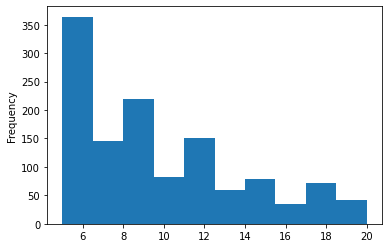

In [34]:
df["delta"].dt.seconds.plot.hist()

In [35]:
df["end_mili"] = pd.to_timedelta(df["end"]).dt.total_seconds()*1000 
df["start_mili"] = pd.to_timedelta(df["start"]).dt.total_seconds()*1000
df.head()

,start,end,sentence,filename,delta,end_mili,start_mili
4,00:04:10.005000,00:04:19.380000,"Aí você me inventa uma entrevista, porra? Uma ...",/home/lucas/Documents/Projetos/audio-transcrip...,00:00:09.375000,259380.0,250005.0
7,00:04:51.546000,00:05:04.171000,Até meu sapato. O sapato? Tem certeza que não ...,/home/lucas/Documents/Projetos/audio-transcrip...,00:00:12.625000,304171.0,291546.0
10,00:05:27.296000,00:05:34.338000,"Depois de um tempo conversando no site, ele te...",/home/lucas/Documents/Projetos/audio-transcrip...,00:00:07.042000,334338.0,327296.0
14,00:06:25.213000,00:06:32.880000,"Não, olha só... Ele não me prometeu nada. Ele....",/home/lucas/Documents/Projetos/audio-transcrip...,00:00:07.667000,392880.0,385213.0
16,00:07:09.505000,00:07:21.213000,Ela não quer fazer natação. Não adianta forçar...,/home/lucas/Documents/Projetos/audio-transcrip...,00:00:11.708000,441213.0,429505.0


In [36]:
df = df.reset_index(drop=True)

In [37]:
df['delta'].sum()

Timedelta('0 days 03:28:40.906000')

In [24]:
processed_path = Path("../data/processed/")
for fname in df["filename"].unique():
    fname_wav = fname.parent / f"{fname.stem}.wav"
    if fname_wav.exists():
        audio = AudioSegment.from_wav(fname_wav.as_posix())
        audio = audio.set_channels(1)
        audio = audio.set_frame_rate(16000)
        output_path = processed_path / str(fname.parent.stem) / str(fname.stem)
        output_path.mkdir(parents=True, exist_ok=True)
        text = ""
        for index, row in df[df["filename"]==fname].iterrows():
            audiocut = audio[row["start_mili"]:row["end_mili"]]
            filename = output_path/ f"{fname.stem}-{index}.flac"
            audiocut.export(filename, format="flac", bitrate="256k")
            text += f"{fname.stem}-{index} {row['sentence']}\n"
        (output_path / f"{fname.stem}.trans.txt").write_text(text)

UnboundLocalError: local variable 'fn' referenced before assignment

In [ ]:
import subprocess
def play(audio_file_path):
    subprocess.call(["ffplay", "-nodisp", "-autoexit", audio_file_path])

In [ ]:
df

In [24]:
item = 288
print(df[df.index == item]['sentence'].item(), df[df.index == item]['delta'].dt.seconds.item())
fname = df[df.index == item]['filename'].item()
audio_path = processed_path / str(fname.parent.stem) / str(fname.stem) / f"{fname.stem}-{item}.flac"
play(audio_path.as_posix())

Eu nunca fiz nada. Nunca matei, nunca estuprei. Quantas mulheres você estragou a vida? Hein, seu bostinha? Olha aqui, todos os meus encontros foram consentidos. -Eu nunca obriguei mulher... -Confessa, porra. 18


In [19]:
import numpy as np
import librosa
from matplotlib import pyplot as plt 

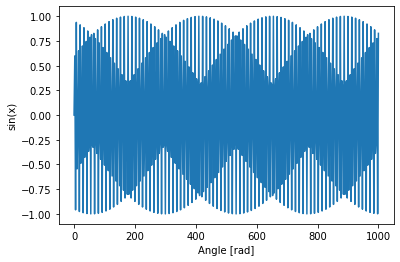

In [40]:
x = np.linspace(0, 1000, 401)
plt.plot(x, np.sin(x))
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()

/home/lucas/Documents/Projetos/audio-transcription/venv/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=401
  n_fft, y.shape[-1]


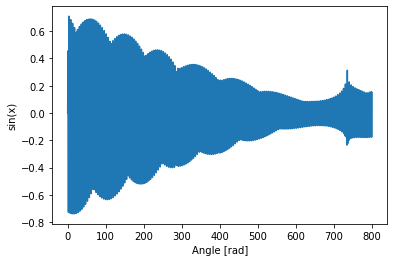

In [41]:
y = librosa.effects.time_stretch(np.sin(x), rate=.5)
plt.plot(y)
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()